Saving advection_dataset.csv to advection_dataset (5).csv
Columns in CSV: Index(['t', 'r', 'theta', 'u(t)', 'u(t+dt)'], dtype='object')
Epoch 0, Loss = 2.993611e-01
Epoch 200, Loss = 2.905713e-10
Epoch 400, Loss = 1.556577e-15
Epoch 600, Loss = 1.216646e-15
Epoch 800, Loss = 1.009449e-08
Epoch 1000, Loss = 6.471931e-08
Epoch 1200, Loss = 2.197512e-08
Epoch 1400, Loss = 2.368144e-08
Epoch 1600, Loss = 5.815559e-06
Epoch 1800, Loss = 6.078684e-08
L2 error: 5.716926e-03
Relative L2 error: 7.382004e-04


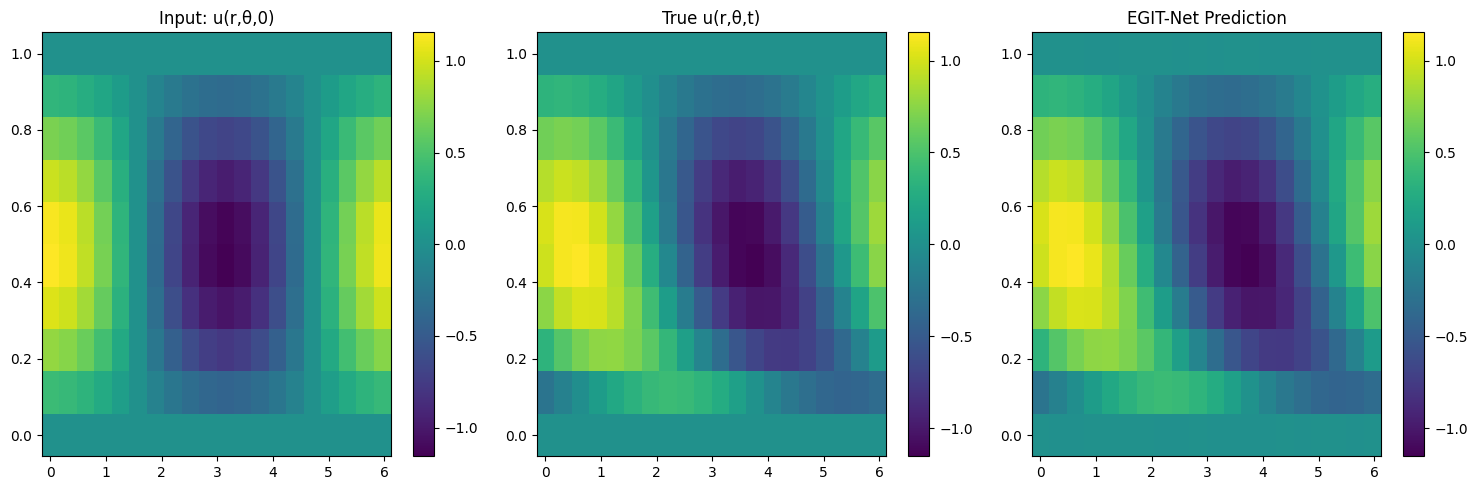

In [7]:
# ===============================================================
# 0. Imports
# ===============================================================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from google.colab import files

# ===============================================================
# 1. Upload CSV dataset
# ===============================================================
uploaded = files.upload()  # Upload your Advection CSV
csv_filename = list(uploaded.keys())[0]

df = pd.read_csv(csv_filename)
print("Columns in CSV:", df.columns)

# ===============================================================
# 2. Extract grid and prepare snapshots
# ===============================================================
u_col = 'u(t)' if 'u(t)' in df.columns else df.columns[-1]

Nr = df['r'].nunique()
Ntheta = df['theta'].nunique()

df = df.sort_values(['t', 'r', 'theta'])

r_vals = np.sort(df['r'].unique())
theta_vals = np.sort(df['theta'].unique())
t_vals = np.sort(df['t'].unique())

# Build input-output pairs: u(t0) -> u(t1)
X_list, Y_list = [], []
for i in range(len(t_vals)-1):
    t0 = t_vals[i]
    t1 = t_vals[i+1]
    u0 = df[df['t']==t0][u_col].to_numpy().reshape(Nr,Ntheta).flatten()
    u1 = df[df['t']==t1][u_col].to_numpy().reshape(Nr,Ntheta).flatten()
    X_list.append(u0)
    Y_list.append(u1)

X = torch.tensor(np.array(X_list), dtype=torch.float32)
Y = torch.tensor(np.array(Y_list), dtype=torch.float32)

# ===============================================================
# 3. Define minimal EGIT-Net
# ===============================================================
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
    def forward(self, x):
        return self.fc(x)

class GITLayer(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(latent_dim, latent_dim)*0.01)
        self.b = nn.Parameter(torch.zeros(latent_dim))
    def forward(self, z):
        return z @ self.W + self.b

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )
    def forward(self, z):
        return self.fc(z)

class EGITNet(nn.Module):
    def __init__(self, input_dim, latent_dim=36):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.git = GITLayer(latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
    def forward(self, x):
        z = self.encoder(x)
        z = self.git(z)
        out = self.decoder(z)
        return out

input_dim = Nr*Ntheta
model = EGITNet(input_dim)

# ===============================================================
# 4. Train the model
# ===============================================================
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(X)
    loss = loss_fn(out, Y)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.6e}")

# ===============================================================
# 5. Prediction on first snapshot
# ===============================================================
u0 = X[0].unsqueeze(0)
u_pred = model(u0).detach().numpy().reshape(Nr,Ntheta)
u_true = Y[0].detach().numpy().reshape(Nr,Ntheta)

# Compute L2 and relative L2 errors
l2_error = np.linalg.norm(u_pred - u_true)
rel_l2_error = l2_error / np.linalg.norm(u_true)
print(f"L2 error: {l2_error:.6e}")
print(f"Relative L2 error: {rel_l2_error:.6e}")

# ===============================================================
# 6. Plot input, true, predicted solutions
# ===============================================================
fig, axs = plt.subplots(1,3,figsize=(15,5))

# Input
im0 = axs[0].pcolormesh(theta_vals, r_vals, u0[0].numpy().reshape(Nr,Ntheta), shading='auto', cmap='viridis')
axs[0].set_title("Input: u(r,θ,0)")
plt.colorbar(im0, ax=axs[0])

# True
im1 = axs[1].pcolormesh(theta_vals, r_vals, u_true, shading='auto', cmap='viridis')
axs[1].set_title("True u(r,θ,t)")
plt.colorbar(im1, ax=axs[1])

# Predicted
im2 = axs[2].pcolormesh(theta_vals, r_vals, u_pred, shading='auto', cmap='viridis')
axs[2].set_title("EGIT-Net Prediction")
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()
